In [1]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier

In [2]:
transactions = pd.read_parquet('data/transactions.parquet')

In [3]:
frauds = pd.read_parquet('data/frauds.parquet');

In [4]:
transactions['is_fraud'] = transactions.index.isin(frauds['transaction_id']).astype(int)

In [5]:
data = transactions

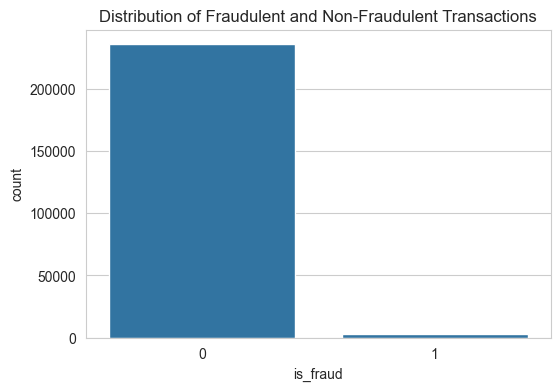

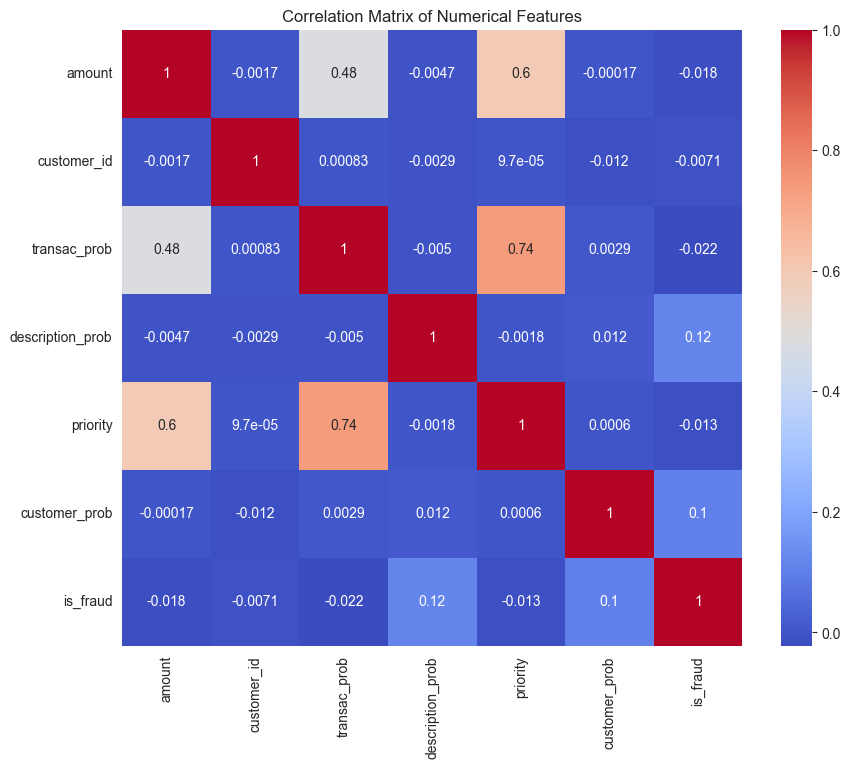

In [6]:
# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

# Distribution of the target variable 'is_fraud'
plt.figure(figsize=(6, 4))
sns.countplot(x='is_fraud', data=data)
plt.title('Distribution of Fraudulent and Non-Fraudulent Transactions')
plt.show()

# Correlation matrix for numerical features
correlation = data.select_dtypes(include=['float64', 'int64']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

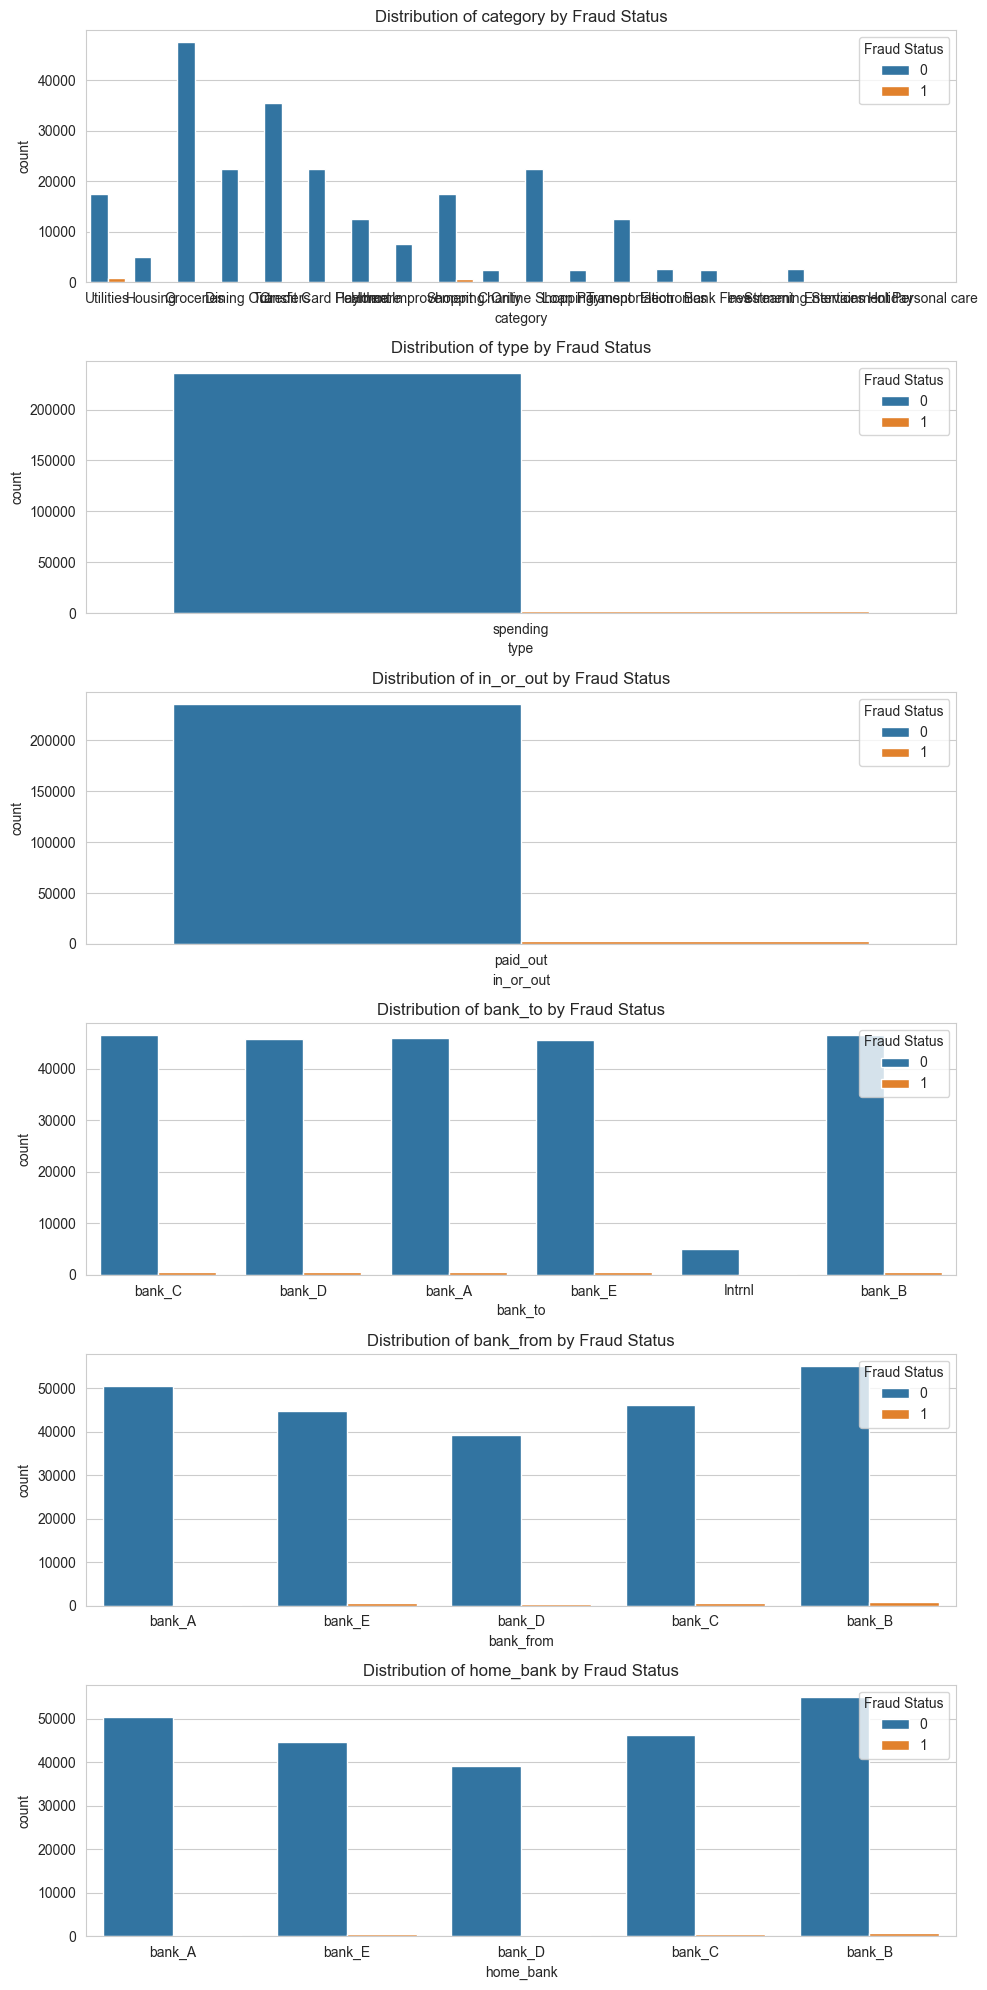

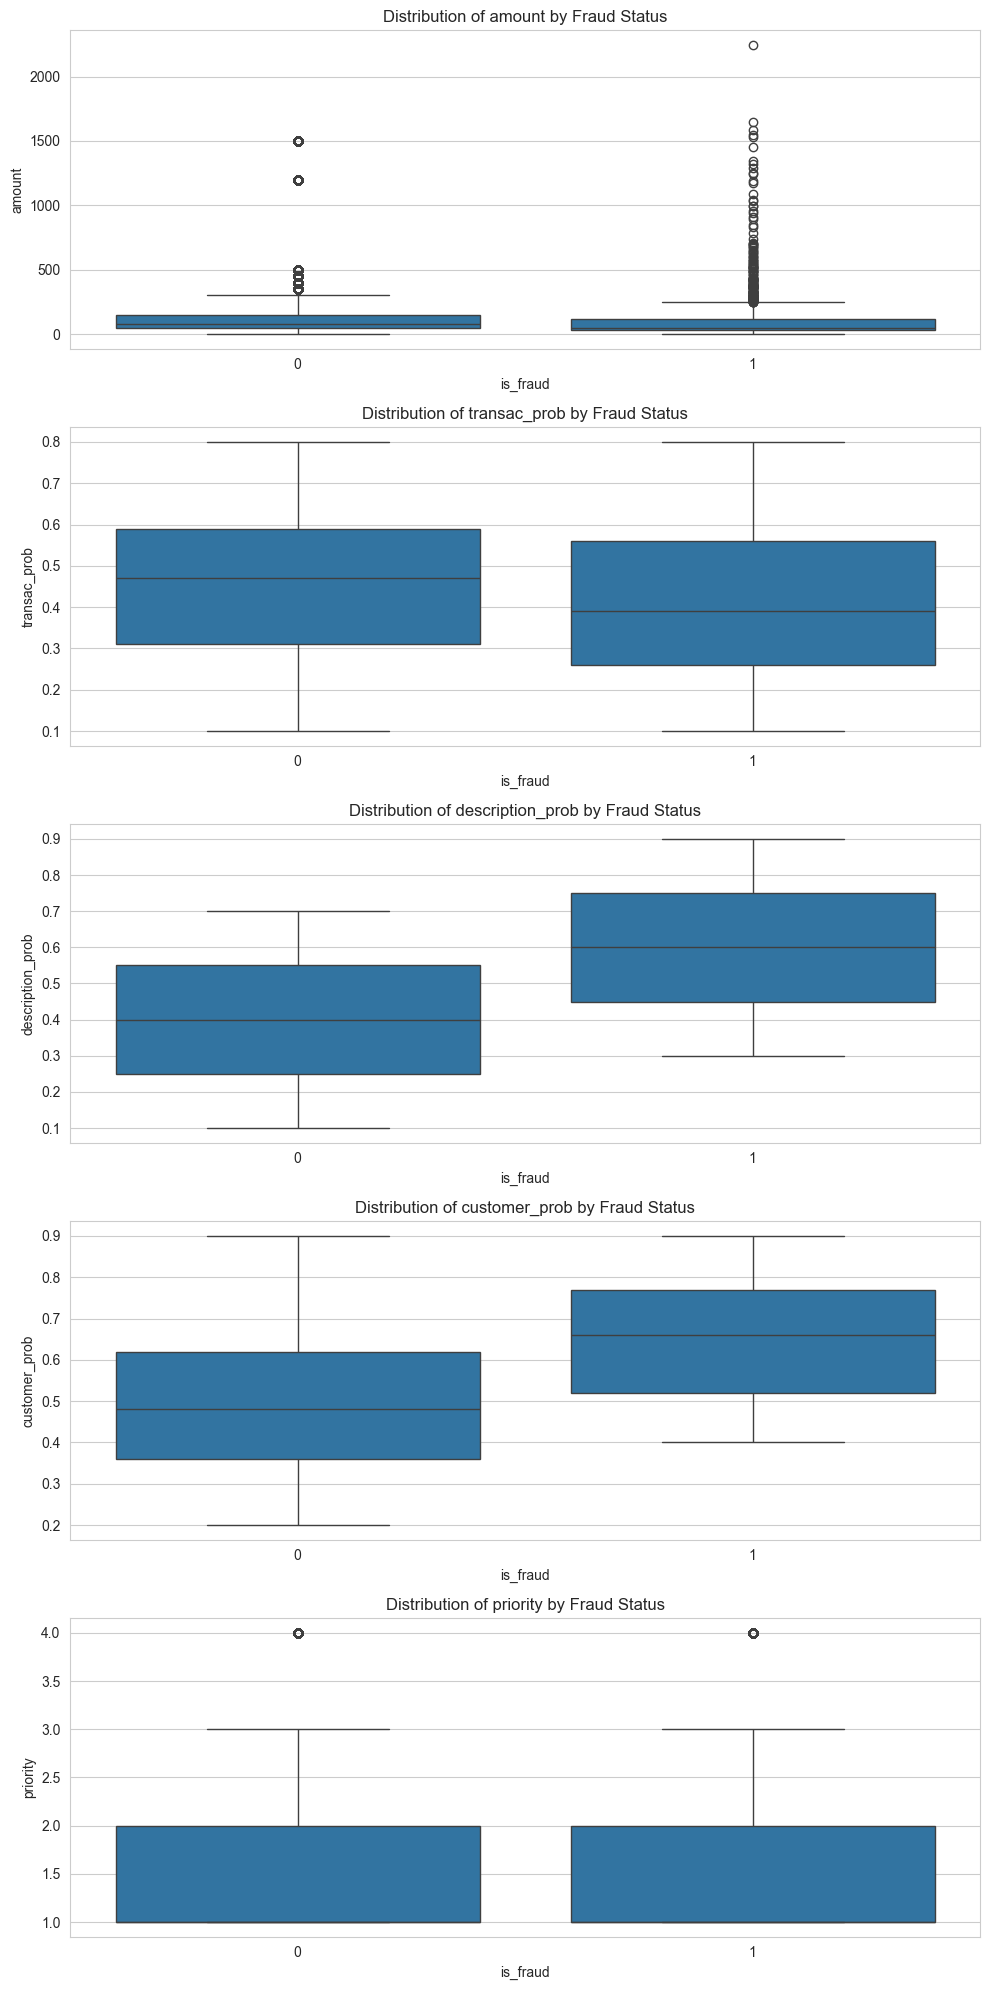

In [7]:
# Categorical features analysis
categorical_features = ['category', 'type', 'in_or_out', 'bank_to', 'bank_from', 'home_bank']

# Plotting distributions of categorical features with respect to the target variable 'is_fraud'
fig, axes = plt.subplots(nrows=len(categorical_features), ncols=1, figsize=(10, 20))
for i, col in enumerate(categorical_features):
    sns.countplot(x=col, hue='is_fraud', data=data, ax=axes[i])
    axes[i].set_title(f'Distribution of {col} by Fraud Status')
    axes[i].legend(title='Fraud Status', loc='upper right')

plt.tight_layout()
plt.show()

# Numerical features analysis
numerical_features = ['amount', 'transac_prob', 'description_prob', 'customer_prob', 'priority']

# Box plots for numerical features
fig, axes = plt.subplots(nrows=len(numerical_features), ncols=1, figsize=(10, 20))
for i, col in enumerate(numerical_features):
    sns.boxplot(x='is_fraud', y=col, data=data, ax=axes[i])
    axes[i].set_title(f'Distribution of {col} by Fraud Status')

plt.tight_layout()
plt.show()

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Label encoding for categorical features
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Converting 'date' into datetime and extracting day of the week and month
data['date'] = pd.to_datetime(data['date'])
data['day_of_week'] = data['date'].dt.dayofweek
data['week_of_year'] = data['date'].dt.isocalendar().week

# Selecting features for the model
features = categorical_features + numerical_features + ['day_of_week', 'week_of_year']
X = data[features]
y = data['is_fraud']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Training a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Getting feature importances
feature_importances = rf.feature_importances_

# Creating a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
8,description_prob,0.336684
6,amount,0.239134
0,category,0.167703
9,customer_prob,0.056218
12,week_of_year,0.054399
7,transac_prob,0.052144
11,day_of_week,0.025866
3,bank_to,0.025483
10,priority,0.023792
5,home_bank,0.009357


In [44]:
# Sorting the data by date
data_sorted = data.sort_values(by='date')

# Preparing for the loop
unique_dates = data_sorted['date'].unique()
balanced = {0: 1, 1: 10}
# Modified SGDClassifier with 'log' loss for probability estimates
# Modified SGDClassifier with 'log' loss for probability estimates
sgd_clf_ev = SGDClassifier(loss='log_loss', class_weight=balanced, random_state=42)
flagged_transactions_ev = []

# Looping over each unique date
for current_date in unique_dates:
    # Select data up to the current date
    current_data = data_sorted[data_sorted['date'] <= current_date]

    # Features and target
    X_current = current_data[features]
    y_current = current_data['is_fraud']

    # Online learning: Update the model with the current day's data
    sgd_clf_ev.partial_fit(X_current, y_current, classes=np.unique(y))

    # Predict fraud probability for the current day's data
    fraud_prob_current = sgd_clf_ev.predict_proba(X_current)[:, 1]

    # Compute expected fraud value: fraud probability * transaction amount
    expected_fraud_value = fraud_prob_current * current_data['amount']

    # Rank transactions by their expected fraud value and select top 100
    top_indices_current = np.argsort(expected_fraud_value)[-100:]
    flagged_transactions_day_ev = current_data.iloc[top_indices_current].index
    flagged_transactions_ev.extend(flagged_transactions_day_ev.tolist())

# Converting flagged transaction IDs to a set to remove duplicates
flagged_transactions_ev = set(flagged_transactions_ev)
flagged_transactions_ev

{3,
 4,
 98307,
 98312,
 10,
 11,
 12,
 13,
 32782,
 15,
 98314,
 17,
 18,
 19,
 98321,
 98322,
 22,
 163859,
 24,
 28,
 32797,
 30,
 34,
 37,
 65576,
 41,
 294956,
 48,
 98355,
 52,
 57,
 58,
 98362,
 131130,
 61,
 62,
 98369,
 98371,
 69,
 98373,
 71,
 98375,
 74,
 32843,
 98381,
 98382,
 229454,
 32850,
 32853,
 86,
 90,
 32859,
 98398,
 95,
 98401,
 98403,
 196709,
 102,
 98406,
 106,
 108,
 98414,
 113,
 163955,
 118,
 98422,
 123,
 124,
 98428,
 126,
 128,
 32897,
 196740,
 135,
 136,
 196743,
 32906,
 139,
 140,
 98445,
 142,
 98444,
 149,
 151,
 153,
 154,
 98459,
 98466,
 164,
 65700,
 166,
 167,
 168,
 170,
 172,
 65710,
 179,
 180,
 192,
 98498,
 200,
 32971,
 98507,
 98509,
 65740,
 32976,
 32977,
 131281,
 214,
 295127,
 223,
 224,
 225,
 164064,
 98533,
 230,
 234,
 98538,
 237,
 33007,
 241,
 33010,
 33011,
 244,
 131314,
 246,
 247,
 248,
 65782,
 98554,
 98555,
 253,
 256,
 98561,
 98562,
 33027,
 260,
 65796,
 98568,
 266,
 33034,
 269,
 270,
 273,
 281,
 98586,
 283,

In [48]:
fidx = list(flagged_transactions_ev)

In [73]:
len(fidx)

5611

In [90]:
investigated = transactions.loc[fidx]
investigated = investigated[investigated['is_fraud'] == 1]

In [94]:
investigated['amount'].sum()

87121.65

In [69]:
all_fraud = transactions[transactions['is_fraud'] == 1]
investifated.groupby('date').sum()['amount'].plot()

253140.40000000002

In [72]:
loss_per_day = all_fraud.groupby('date').sum()['amount'] - investigated.groupby('date').sum()['amount']
loss_per_day

date
2023-10-01    326.95
2023-10-02    180.80
2023-10-03    584.55
2023-10-04    235.70
2023-10-05    166.75
               ...  
2024-07-27       NaN
2024-07-28       NaN
2024-07-29       NaN
2024-07-30       NaN
2024-07-31       NaN
Name: amount, Length: 305, dtype: float64

In [70]:
total_loss = all_fraud.groupby('date').sum()['amount'].sum() - investigated.groupby('date').sum()['amount'].sum()

In [71]:
total_loss

166018.75000000003

In [85]:
all_fraud.groupby('date').sum()['amount'].sum()

253140.40000000002

'/Users/uzaykaradag/Desktop/mmcs-sopra-steria/plot_fuck_this_shit.svg'

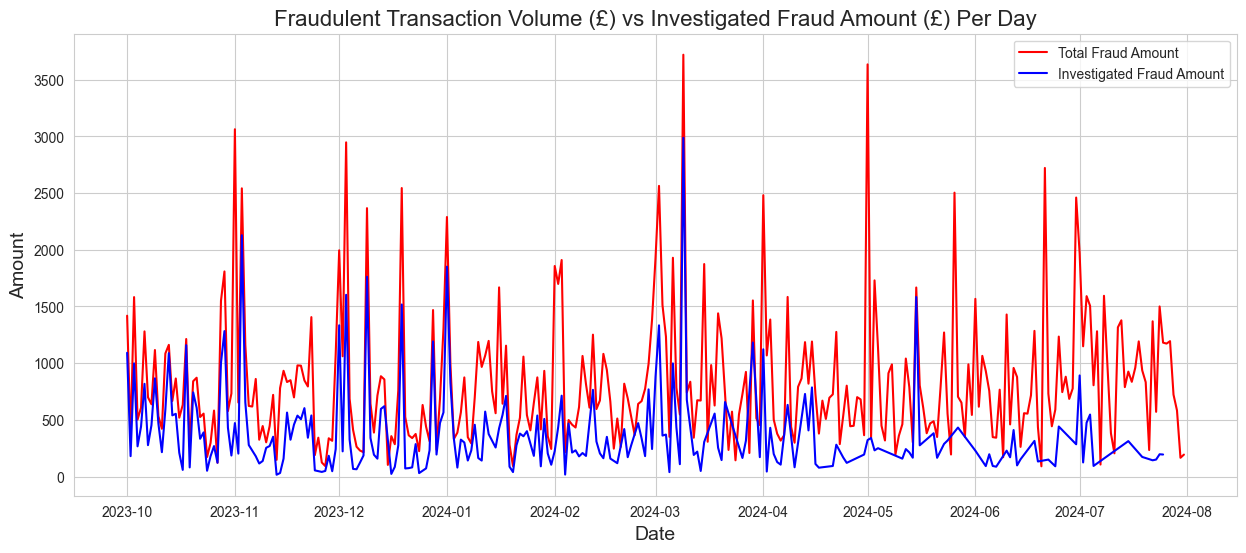

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data for plotting
all_fraud = data[data['is_fraud'] == 1]
total_fraud_per_day = all_fraud.groupby('date').sum()['amount']

investigated = data.loc[list(flagged_transactions_ev)]
investigated_fraud = investigated[investigated['is_fraud'] == 1]
investigated_fraud_per_day = investigated_fraud.groupby('date').sum()['amount']

loss_per_day = total_fraud_per_day - investigated_fraud_per_day

# Exporting the plot to an SVG file
plot_file_path = '/Users/uzaykaradag/Desktop/mmcs-sopra-steria/plot_fuck_this_shit.svg'
plt.figure(figsize=(15, 6))

# Total fraud amount per day
sns.lineplot(x=total_fraud_per_day.index, y=total_fraud_per_day, label='Total Fraud Amount', color='red')

# Investigated fraud amount per day
sns.lineplot(x=investigated_fraud_per_day.index, y=investigated_fraud_per_day, label='Investigated Fraud Amount', color='blue')

# Adding titles and labels
plt.title(r'Fraudulent Transaction Volume (£) vs Investigated Fraud Amount (£) Per Day', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Amount', fontsize=14)
plt.legend()

# Save the plot to a file
plt.savefig(plot_file_path, format='svg')

plot_file_path

In [76]:
total_fraud_per_day

date
2023-10-01    1418.75
2023-10-02     360.95
2023-10-03    1582.80
2023-10-04     502.45
2023-10-05     606.85
               ...   
2024-07-27    1194.25
2024-07-28     722.35
2024-07-29     583.45
2024-07-30     165.60
2024-07-31     193.70
Name: amount, Length: 305, dtype: float64

In [84]:
investigated_fraud_per_day

date
2023-10-01    1091.80
2023-10-02     180.15
2023-10-03     998.25
2023-10-04     266.75
2023-10-05     440.10
               ...   
2024-07-19     173.05
2024-07-22     143.60
2024-07-23     150.00
2024-07-24     196.70
2024-07-25     194.40
Name: amount, Length: 224, dtype: float64